In [498]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import netcdf_file

In [499]:
f = netcdf_file('data2.nc', mmap=False)

#### Extract the variables from the data

In [500]:
lon = f.variables['longitude'].data.copy()
lat = f.variables['latitude'].data.copy()
times = f.variables['time'].data.copy()

raw_vel_x = f.variables['ugos'].data.copy().squeeze()
raw_vel_y = f.variables['vgos'].data.copy().squeeze()

In [501]:
print("Lon shape",lon.shape)
print("Lat shape",lat.shape)
print("vel_x shape",raw_vel_x.shape)
print("vel_y shape",raw_vel_y.shape)

Lon shape (81,)
Lat shape (321,)
vel_x shape (321, 81)
vel_y shape (321, 81)


#### Fix missing data

In [502]:
from common_functions import interpolate_missing_point

vel_x = interpolate_missing_point(raw_vel_x, np.ma.masked_invalid(raw_vel_x).mask)
vel_y = interpolate_missing_point(raw_vel_y, np.ma.masked_invalid(raw_vel_y).mask)

#### Start with reducing size of the coord grid to make easier

In [503]:
vel_x[0:321,0:321].shape


(321, 81)

In [504]:
condition = False
if condition:
    [lon_min,lon_max,lat_min,lat_max] = [10,40,60,82]

    lon = lon[lon_min:lon_max]
    lat = lat[lat_min:lat_max]
    vel_x = vel_x[lat_min:lat_max,lon_min:lon_max]
    vel_y = vel_y[lat_min:lat_max,lon_min:lon_max]

#### Plot vel_x and vel_y to check all good

Text(0.5, 1.0, 'Vel_y')

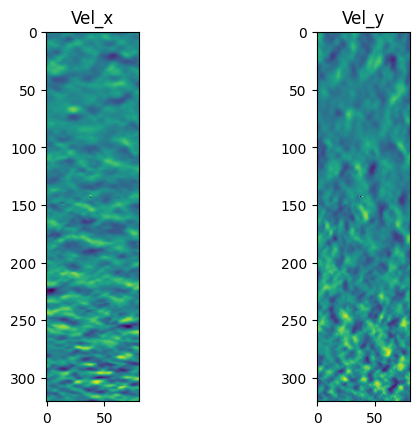

In [505]:
ax1 = plt.subplot(1,2,1)
ax1.imshow(vel_x)
ax1.set_title("Vel_x")

ax2 = plt.subplot(1,2,2)
ax2.imshow(vel_y)
ax2.set_title("Vel_y")

Are those little dots a problem??

#### Quiver plot for visualising velocities

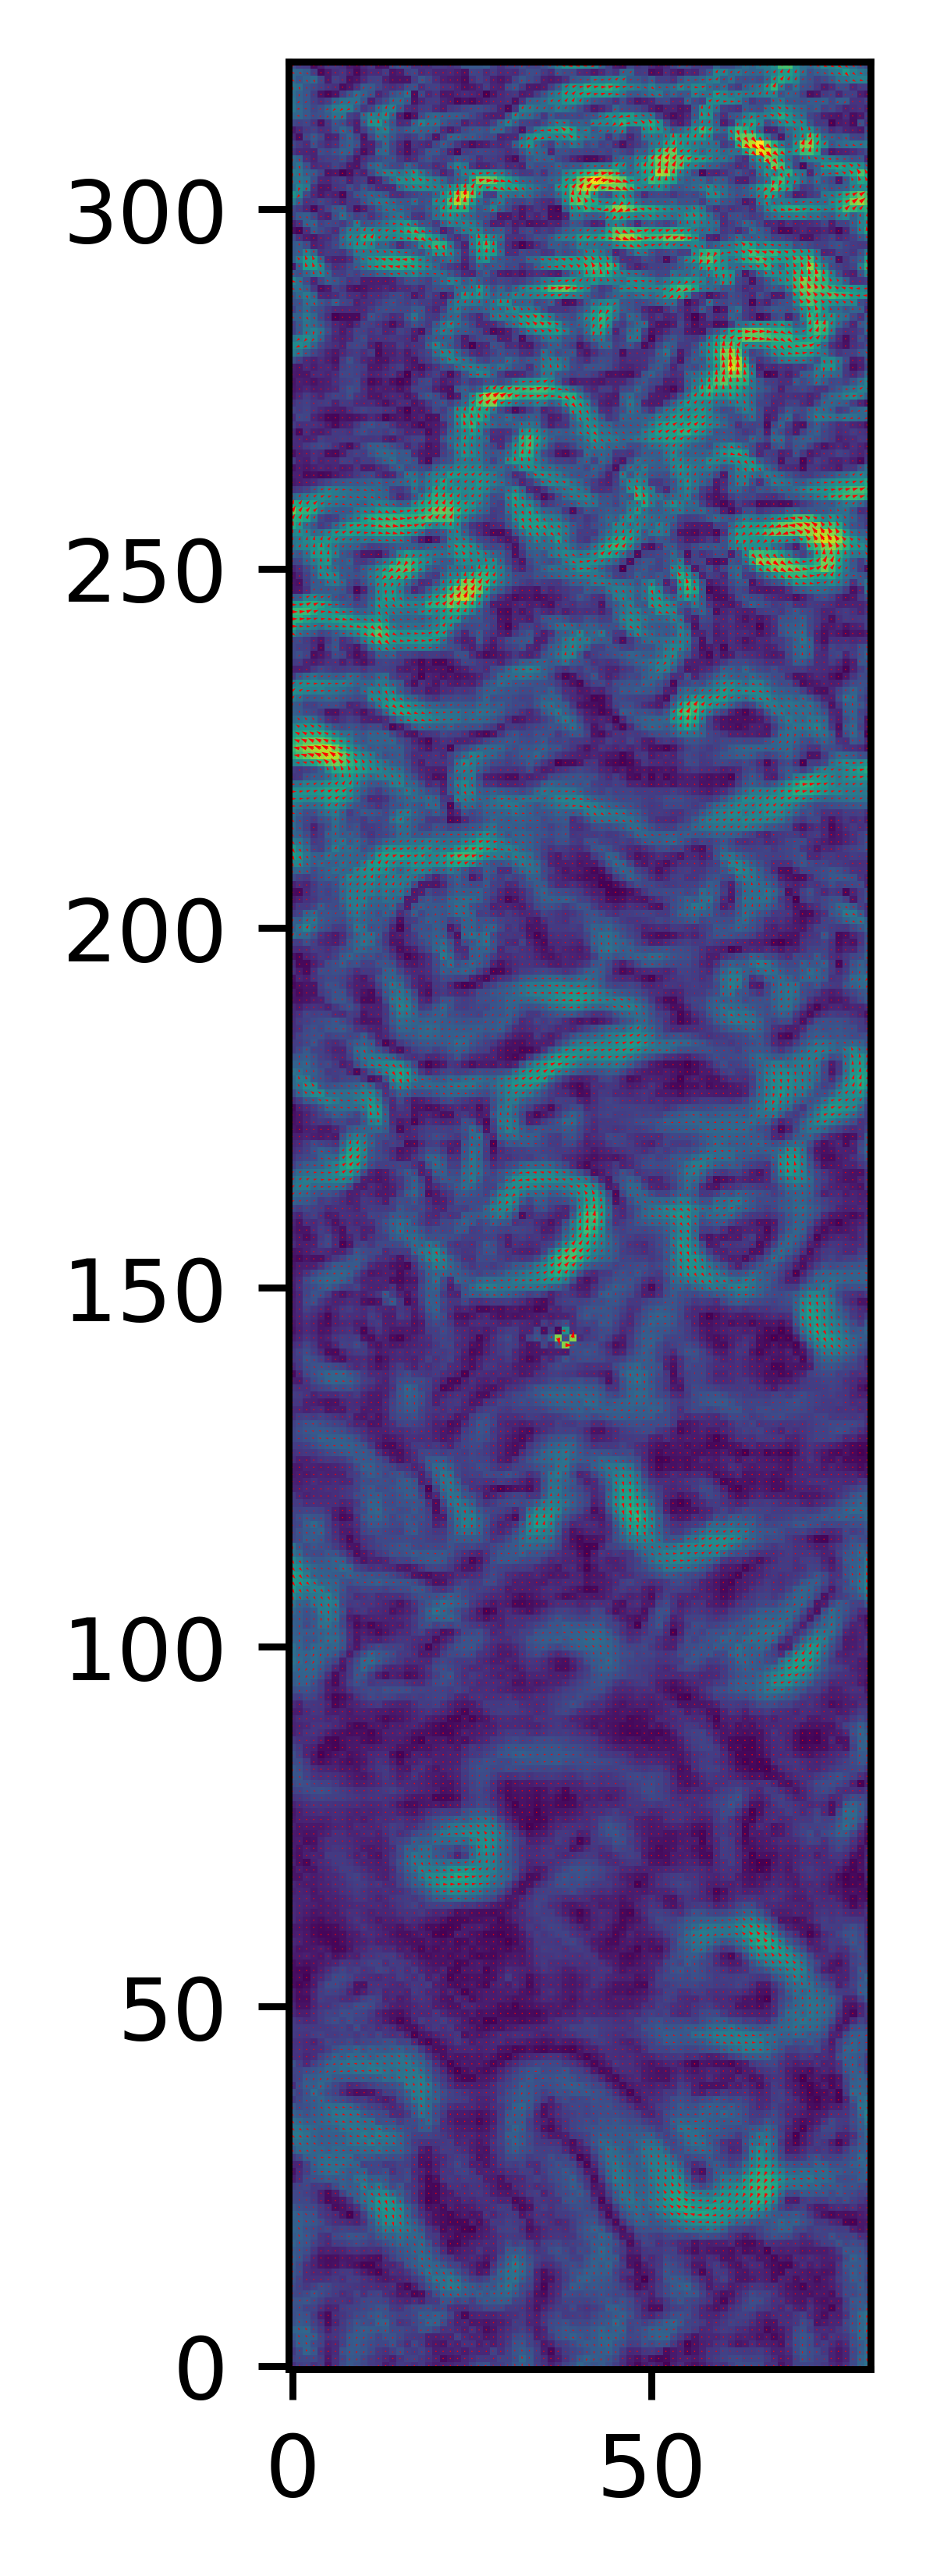

In [506]:
vel_magnitude = np.hypot(vel_x, vel_y)

# start with magnitude of velocity as background

plt.figure(dpi=800)
plt.imshow(vel_magnitude, origin='lower')
plt.quiver(vel_x, vel_y, color='r')

#### Now to begin the algorithm

#### Step 1: Compute the normal vector at each point in the grid

Note: the normal vectors could be either positive or negative. Depending on the rotation of the eddy, I think the vectors will either point all out or all in. So possibly need to do twice, taking negative normal second time.
$$
\text{If}
\\
\mathbf{v} = (x,y)
\\
\text{then either}
\\
\mathbf{n} = (-y,x) = \mathbf{n_1}
\\
\text{or}
\\
\mathbf{n} = -\mathbf{n_1} = (y,-x) = \mathbf{n_2}

In [507]:
vel_norm_x = - vel_y
vel_norm_y = vel_x

Calculate angle theta as
$$ \theta = \arctan(\frac{y}{x})

In [508]:
normal_theta = np.arctan2(vel_norm_y,vel_norm_x)

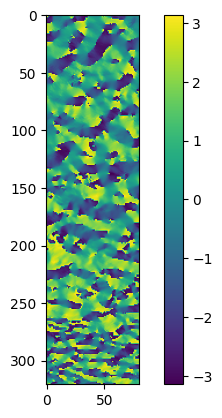

In [509]:
plt.imshow(normal_theta)
plt.colorbar()

In [511]:
def calc_grid_direction(theta,i,j):
    #theta is angle in radians of the direction of the vector. Measured anticlockwise from the horizontal
    #i,j are the x,y indeces of the cell of the vector
    #returns output of the cell the vector is pointing to

    #Initialise output indices as same as current cell
    i_out = i
    j_out = j

    #Determine which region angle falls in
    if -np.pi/8 < theta <= np.pi/8:
        cell = 1
        i_out += 1
    elif np.pi/8 < theta <= 3*np.pi/8:
        cell = 2
        i_out += 1
        j_out += 1
    elif 3*np.pi/8 < theta <= 5*np.pi/8:
        cell = 3
        j_out += 1
    elif 5*np.pi/8 < theta <= 7*np.pi/8:
        cell = 4
        i_out -= 1
        j_out += 1
    elif 7*np.pi/8 < theta <= np.pi or -np.pi < theta <= -7*np.pi/8:
        cell = 5
        i_out -= 1
    elif -7*np.pi/8 < theta <= -5*np.pi/8:
        cell = 6
        i_out -= 1
        j_out -= 1
    elif -5*np.pi/8 < theta <= -3*np.pi/8:
        cell = 7
        j_out -= 1
    elif -3*np.pi/8 < theta <= -np.pi/8:
        cell = 8
        i_out += 1
        j_out -= 1

    return cell,i_out,j_out

In [512]:
#Check angles working as intended
test_vels = [[0,0],[1,1],[0,1],[-1,1],[-1,0],[-1,-1],[0,-1],[1,-1]]
for vel in test_vels:
    x = vel[0]
    y = vel[1]
    angle = np.arctan2(y,x)
    print(calc_grid_direction(angle,10,10))

(1, 11, 10)
(2, 11, 11)
(3, 10, 11)
(4, 9, 11)
(5, 9, 10)
(6, 9, 9)
(7, 10, 9)
(8, 11, 9)


In [513]:
class grid_cell:
    def __init__(self):
        self.num_pointed_from = 0
        self.indices_pointed_from = np.array([[]]) #np.empty((1,1))
        #self.indices_pointed_from = indices_pointed_from
    def set_num_pointed_from(self,new_val):
        self.num_pointed_from = new_val
    def add_new_pointed_from(self,new_coord):
        self.indices_pointed_from = np.array(np.vstack([self.indices_pointed_from,new_coord]) if self.indices_pointed_from.size else new_coord)
        # self.indices_pointed_from = np.concatenate((self.indices_pointed_from,new_coord))

In [514]:
#Setup array of grid_cell objects
grid_neighbours = np.array( [ [ grid_cell() for i in range(0,theta.shape[1]) ] for j in range(0,theta.shape[0]) ],dtype=object)

for i in range(0,theta.shape[0]):
    for j in range(0,theta.shape[1]):

        direction_pointing, target_i,target_j = calc_grid_direction(theta[i,j],i,j)

        #Check if neighbour if within the grid
        if 0 <= target_i <= theta.shape[0]-1 and 0 <= target_j <= theta.shape[1]-1:
            # print(i," - ",target_i,"  ",j," - ",target_j)
            
            # neighbour_count[target_i,target_j] += 1
            grid_neighbours[target_i,target_j].num_pointed_from += 1



Check if any cells have a high enough neighbours to constitute an eddy

In [515]:
max_no_cells_pointed = 0

for i in range(0,theta.shape[0]):
    for j in range(0,theta.shape[1]):
        if grid_neighbours[i,j].num_pointed_from > max_no_cells_pointed:
            max_no_cells_pointed = grid_neighbours[i,j].num_pointed_from

max_no_cells_pointed

3

Maybe end algorithm if max_no_cells_pointed < 4